# Read Spectrums from Atomtex detectors and spatial analysis of contamination

All spectrus in spe-format are in a single folder.
Spectrums are loaded in a dataframe.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import sys


In [2]:
def read_spectrs(directory, tp='spe'):
  '''
   Считывает файлы спектров (канал, время-дата, температура и т.п.) 
   в формате spe
   с расширением tp из заданной папки directory
   и помещает их в dataframe
   Procedure for reading files from folder
   retrieving data on counts in channels, date-time, temperature etc.
  '''
  detector = []
  det_num = []
  cps = []
  temp = []
  date_time = []
  mestime = []
  dose = []
  energ_cal = []
  for fl in os.listdir(directory):
    if tp in fl:
      with open(directory+fl, 'r', encoding='cp1251') as spectr:
        flag = ''
        chanl = -1
        for line in spectr:
          if 'COM' in line:
            tdat = line.split(' ')
            detector.append(tdat[1])
            det_num.append(tdat[2][3:-1])
          if flag == 'data' and chanl >= 0:
            spec[chanl] = int(line.strip())
            chanl += 1
            if chanl > nchanl :
              flag = ''
              chanl = -1
              try :
                spectrums
              except NameError :
                spectrums = spec.reshape(1, -1)
              else :
                spectrums = np.vstack((spectrums, spec.reshape(1, -1)))
          if flag == 'data' and chanl == -1:
            chanl = 0
            nchanl = int(line.split(' ')[1])
            spec = np.zeros(nchanl+1)
          if '$DATA' in line:
            flag = 'data'
          if flag == 'enrg':
            energ = line.split(' ')
            energ[0] = float(energ[0])
            energ[1] = float(energ[1])
            energ_cal.append(energ)
            flag = ''
          if '$ENER_FIT' in line:
            flag = 'enrg'
          if flag == 'date':
            dat_time = line.split(' ')
            dat = dat_time[0].split('/')
            time = dat_time[1].split(':')
            dat_time = datetime(int(dat[2]), int(dat[0]), int(dat[1]), int(time[0]), int(time[1]), int(time[2]))
            date_time.append(dat_time)
            flag = ''
          if '$DATE_MEA' in line:
            flag = 'date'
          if flag == 'dose':
            dose.append(float(line))
            flag = ''
          if '$DOSE_RATE' in line:
            flag = 'dose'          
          if flag == 'mestm':
            mes_time = line.split(' ')
            mestime.append([int(mes_time[0]), int(mes_time[1])])
            flag = ''
          if '$MEAS_TIM' in line:
            flag = 'mestm'
          if flag == 'cps':
            cps.append(float(line))
            flag = ''
          if '$CPS' in line:
            flag = 'cps'
          if flag == 'temp':
            temp.append(float(line))
            flag = ''
          if '$TEMPERATURE' in line:
            flag = 'temp'  
  chanls = []
  for i in range(1,spectrums.shape[1]+1):
    chanls.append('ch_'+str(i))
  heads = chanls[:]
  spectrums = np.hstack((spectrums, np.array(cps).reshape(-1, 1)))
  spectrums = np.hstack((spectrums, np.array(mestime).reshape(-1, 2)))
  spectrums = np.hstack((spectrums, np.array(date_time).reshape(-1, 1)))
  spectrums = np.hstack((spectrums, np.array(temp).reshape(-1, 1)))
  spectrums = np.hstack((spectrums, np.array(detector).reshape(-1, 1)))
  spectrums = np.hstack((spectrums, np.array(det_num).reshape(-1, 1)))
  spectrums = np.hstack((spectrums, np.array(dose).reshape(-1, 1)))
  spectrums = np.hstack((spectrums, np.array(energ_cal).reshape(-1, 2)))

  heads.append('cps')
  heads.append('live_mes_time')
  heads.append('total_mes_time')
  heads.append('date_time')
  heads.append('temperature')
  heads.append('detector_type')
  heads.append('detector_num')
  heads.append('dose_rate') # nSv/h
  heads.append('energ_cal_0')
  heads.append('energ_cal_1')
  data = pd.DataFrame(data=spectrums, columns=heads)
  data[chanls] = data[chanls].astype('int')
  data[['live_mes_time', 'total_mes_time']] = data[['live_mes_time', 'total_mes_time']].astype('int')
  data[['cps', 'temperature', 'dose_rate', 'energ_cal_0', 'energ_cal_1']] = data[['cps', 'temperature', 'dose_rate', 'energ_cal_0', 'energ_cal_1']].astype('float')
  data['date_time'] = pd.to_datetime(data['date_time'])
  return data


In [3]:
from pykml import parser
from shapely.geometry import Point
import geopandas as gpd
from matplotlib import pyplot as plt

def read_track(trackfile):
  '''
   Считывает маршрут с временной привязкой и скоростью перемещения, 
   полученный с помощью программы
   Геотрекер для Android от Ильи Богдановича
   https://play.google.com/store/apps/details?id=com.ilyabogdanovich.geotracker
   и помещает их в dataframe
   Procedure for reading route data from file generated with
   app Geotracker for Android from Илья Богданович
   https://play.google.com/store/apps/details?id=com.ilyabogdanovich.geotracker
  '''

  with open(trackfile) as f:
    track = parser.parse(f)
  points = track.findall('.//{http://www.google.com/kml/ext/2.2}coord')
  timestamps = track.findall('.//{http://www.google.com/kml/ext/2.2}Track//{http://www.opengis.net/kml/2.2}when')
  speeds = track.findall('.//{http://www.google.com/kml/ext/2.2}SimpleArrayData[@name="speed"]//{http://www.google.com/kml/ext/2.2}value')
  points = [point.text.split(' ') for point in points]
  points = np.array(points, dtype='float')
  geometry = [Point(x, y) for x, y in points[:, :2]]
  crs = {'init': 'epsg:4326'}
  data = gpd.GeoDataFrame(crs=crs, geometry=geometry)
  data['elevation'] = points[:, 2]
  speeds = [float(dat.text) for dat in speeds]
  speeds = np.array(speeds).reshape(-1,1)
  data['speed'] = speeds
  timestamps = [dat.text for dat in timestamps]
  data['date_time'] = timestamps
  data['date_time'] = pd.to_datetime(data['date_time'], infer_datetime_format=True)
  return data

In [4]:
from datetime import timedelta
import geoplot as gpl
import contextily as ctx

def concatenate_spectrum_geo(spectrum_folder, track_file_kml, time_to_minsk=False, spectrum_london=True, timedelta='15s'):
  '''
   Concatenation spectrums with geodata on time labels
  '''
  # Читаем файл маршрута
  data = read_track(track_file_kml)
  
  if time_to_minsk:
  # Конвертируем вермя в минское
    data['date_time'] = data['date_time'].dt.tz_convert('Europe/Minsk')
  data = data.sort_values(by='date_time')

  # Читаем файлы спектров, загружаем спектры в DataFrame
  data2 = read_spectrs(directory=spectrum_folder)
  if time_to_minsk and spectrum_london:
    data2['date_time'] = data2['date_time'].dt.tz_localize(tz='Europe/London').dt.tz_convert('Europe/Minsk')
  elif not spectrum_london and time_to_minsk:
    data2['date_time'] = data2['date_time'].dt.tz_localize(tz='Europe/Minsk')
  data2['midtime'] = data2['date_time'] - pd.to_timedelta(data2['total_mes_time']/2, unit='s')
  data2 = data2.sort_values(by='midtime').reset_index()
 
  # Объединяем данные спектров и гео-координат (left-join), слева спектры
  merged_data = pd.merge_asof(data2, data, left_on='midtime', right_on='date_time', suffixes=('_spectrum', '_geo'), direction='nearest', tolerance=pd.Timedelta(timedelta))
  crs = {'init': 'epsg:4326'}
  merged_data = gpd.GeoDataFrame(merged_data, crs=crs, geometry=merged_data['geometry'])
  return merged_data


Processing data from exclusion zone of Chernobyl NPP

In [5]:
# Choiniki - Dronki - Krasnoselie - Choiniki - Gomel
trackfile = "/home/alex/eScience/spectrum/2019_10_31_Dronki/2019_10_31_dronki.kml"
directory = '/home/alex/eScience/spectrum/2019_10_31_Dronki/'

merged = concatenate_spectrum_geo(directory, trackfile, time_to_minsk=True, timedelta='15s')
merged[merged['speed'].notna()]['midtime'].nunique()

818

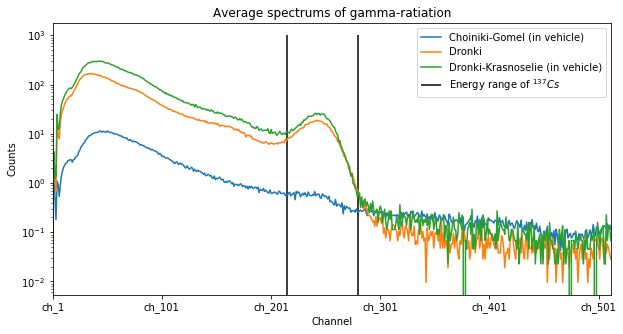

In [6]:
# sample plot in Dronki filtered by timestamp
start = pd.Timestamp(2019, 10, 31, 9, 40).tz_localize('Europe/Minsk')
finish = pd.Timestamp(2019, 10, 31, 11, 37).tz_localize('Europe/Minsk')
part1 = merged[(merged['date_time_geo'] > start) & (merged['date_time_geo'] < finish)] 
#[['dose_rate', 'elevation', 'speed', 'midtime', 'geometry']]

# Choiniki-Gomel (in vehicle) filtered by timestamp
start = pd.Timestamp(2019, 10, 31, 15, 50).tz_localize('Europe/Minsk')
finish = pd.Timestamp(2019, 10, 31, 17, 30).tz_localize('Europe/Minsk')
part2 = merged[(merged['date_time_geo'] > start) & (merged['date_time_geo'] < finish)] 

# Dronki - Krasnoselie (in vehicle) filtered by timestamp
start = pd.Timestamp(2019, 10, 31, 12, 10).tz_localize('Europe/Minsk')
finish = pd.Timestamp(2019, 10, 31, 12, 40).tz_localize('Europe/Minsk')
part3 = merged[(merged['date_time_geo'] > start) & (merged['date_time_geo'] < finish)] 

fig, ax = plt.subplots(figsize=(10,5))
part2.loc[:, 'ch_1':'ch_512'].mean(axis=0).plot(ax=ax, label='Choiniki-Gomel (in vehicle)')
part1.loc[:, 'ch_1':'ch_512'].mean(axis=0).plot(ax=ax, label='Dronki')
part3.loc[:, 'ch_1':'ch_512'].mean(axis=0).plot(ax=ax, label='Dronki-Krasnoselie (in vehicle)')
ax.set_yscale('log')
plt.vlines(215, ymin=0, ymax=10e2, label='Energy range of $^{137}Cs$')
plt.vlines(280, ymin=0, ymax=10e2)
plt.title('Average spectrums of gamma-ratiation')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.legend()
plt.show()

In [7]:
# Masany - Choiniki
trackfile = "/home/alex/eScience/spectrum/2019_10_31_Masany/2019_10_30_masany.kml"
directory = '/home/alex/eScience/spectrum/2019_10_31_Masany/'
merged2 = concatenate_spectrum_geo(directory, trackfile, time_to_minsk=True, timedelta='15s')
merged2[merged2['speed'].notna()]['midtime'].nunique()

331

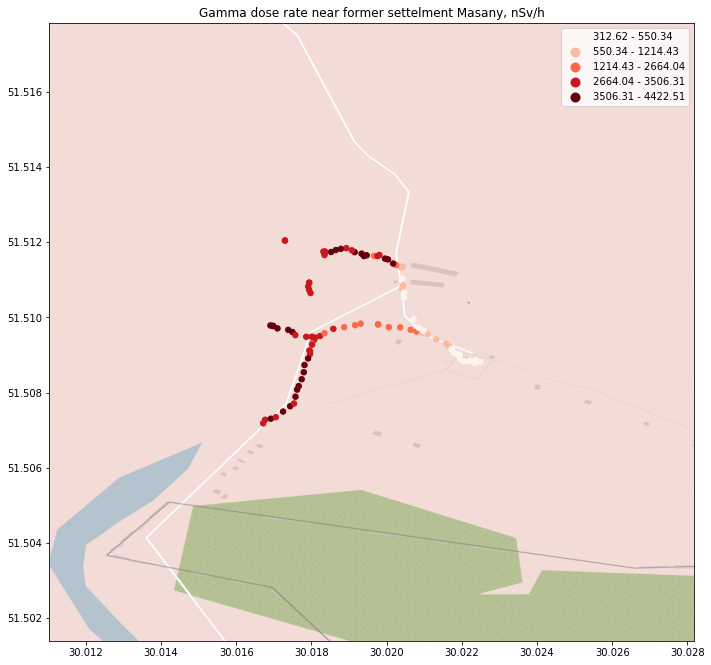

In [8]:
start = pd.Timestamp(2019, 10, 30, 11, 10).tz_localize('Europe/Minsk')
finish = pd.Timestamp(2019, 10, 30, 14, 19).tz_localize('Europe/Minsk')
part = merged2[(merged2['date_time_geo'] > start) & (merged2['date_time_geo'] < finish)] 
#[['dose_rate', 'elevation', 'speed', 'midtime', 'geometry']]

ax = part.plot(column='dose_rate', cmap="Reds", 
          markersize=30, scheme='natural_breaks', 
          legend=True, figsize=(10,10))
ctx.add_basemap(ax, crs=part.crs, zoom=18, url=ctx.sources.OSM_A)
plt.title('Gamma dose rate near former settelment Masany, nSv/h')
plt.tight_layout()
plt.show()

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


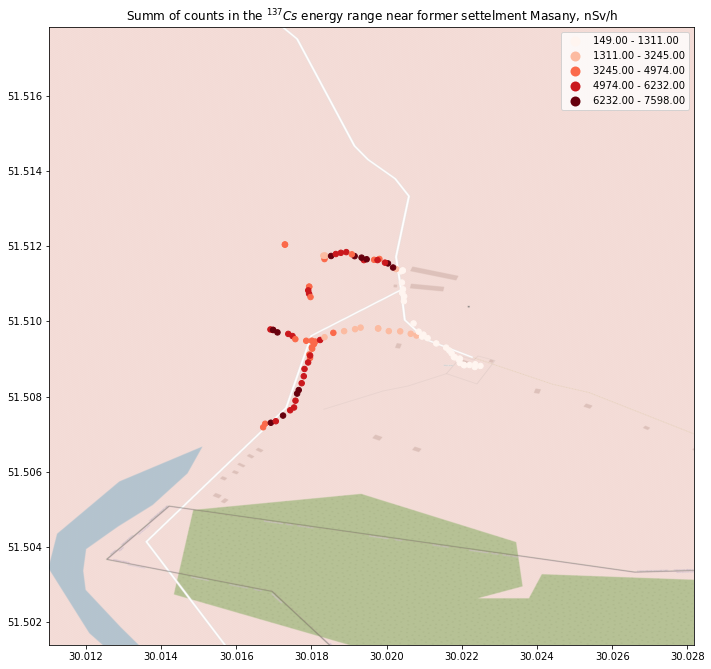

In [9]:
cs_counts = part.loc[:, 'ch_215':'ch_280'].sum(axis=1)
part['cs_counts'] = cs_counts
ax = part.plot(column='cs_counts', cmap="Reds", 
          markersize=30, scheme='natural_breaks', 
          legend=True, figsize=(10,10))
ctx.add_basemap(ax, crs=part.crs, zoom=18, url=ctx.sources.OSM_A)
plt.title('Summ of counts in the $^{137}Cs$ energy range near former settelment Masany, nSv/h')
plt.tight_layout()
plt.show()

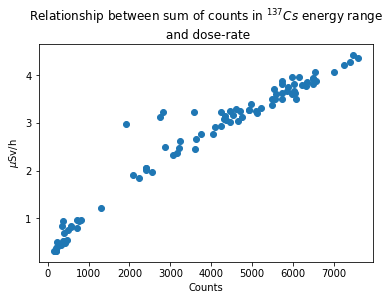

In [10]:
plt.scatter(part['cs_counts'], part['dose_rate']/1000)
plt.xlabel('Counts')
plt.ylabel('$\mu$Sv/h')
plt.title('Relationship between sum of counts in $^{137}Cs$ energy range \n and dose-rate')
plt.show()

Gamma-dose rate mainly depend on contamination the sites with <sup>137</sup>Cs. However, three points are very distant from common pattern of the relationship. They have much higher dose rate than we can predict from the counts in the <sup>137</sup>Cs energy range.

In [11]:
from sklearn.linear_model import LinearRegression as lr
# we will use sites with cs_counts > 1500 only, because linearity of this part
Y = part.loc[part['cs_counts'] > 1500, 'dose_rate'].values.reshape(-1, 1)
X = part.loc[part['cs_counts'] > 1500, 'cs_counts'].values.reshape(-1, 1)
model = lr().fit(X, Y)
model.score(X, Y)

0.8706938276593099

In [12]:
y_diff = part.dose_rate.values.reshape(-1, 1) - model.predict(part.cs_counts.values.reshape(-1,1))
part['y_diff'] = y_diff

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/alex/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


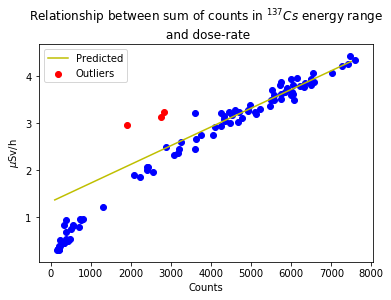

In [13]:
part['outlier'] = False
# separate sites with difference between actual and predicted dose rate > 500 nSv/h
part.loc[part.y_diff > 500, 'outlier'] = True
fig, ax = plt.subplots()
ax.plot(np.arange(100,7500), 
           model.predict(np.arange(100,7500).reshape(-1,1))/1000,
           c='y', label='Predicted')
ax.scatter(part.loc[~part.outlier, 'cs_counts'], 
           part.loc[~part.outlier, 'dose_rate']/1000,
           c='b', label=None)
ax.scatter(part.loc[part.outlier, 'cs_counts'], 
           part.loc[part.outlier, 'dose_rate']/1000,
           c='r', label='Outliers')
plt.xlabel('Counts')
plt.ylabel('$\mu$Sv/h')
plt.legend()
plt.title('Relationship between sum of counts in $^{137}Cs$ energy range \n and dose-rate')
plt.show()

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


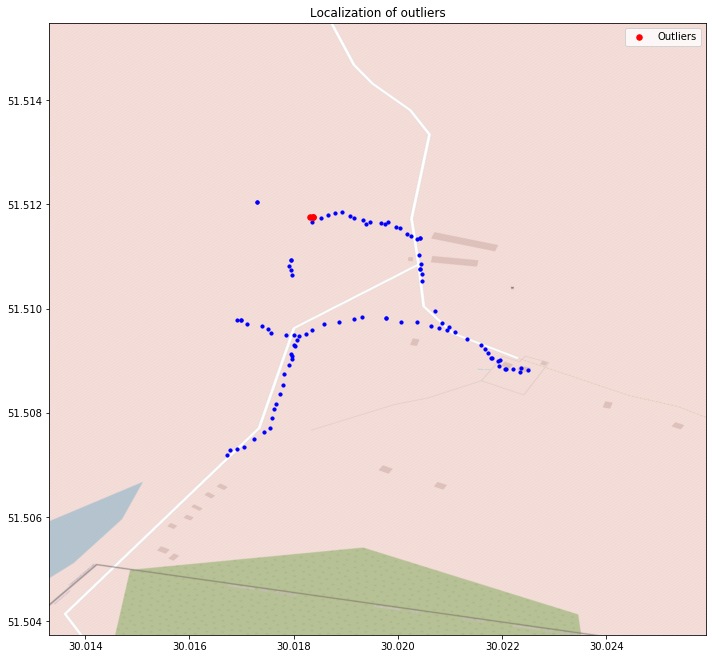

In [14]:
cs_counts = part.loc[:, 'ch_215':'ch_280'].sum(axis=1)
part['cs_counts'] = cs_counts
ax = part[~part.outlier].plot(markersize=10, c='b', figsize=(10,10))
part[part.outlier].plot(markersize=30, c='r', ax=ax, label='Outliers')
ctx.add_basemap(ax, crs=part.crs, zoom=18, url=ctx.sources.OSM_A)
plt.title('Localization of outliers')
plt.legend()
plt.tight_layout()
plt.show()

All outliers are localized close to each over.

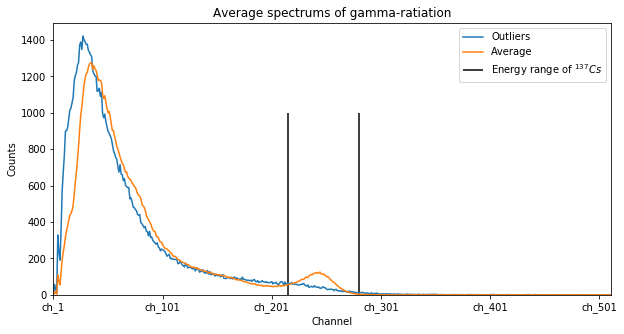

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
aver = (part.dose_rate > 2500) & (part.dose_rate < 3500) & ~part.outlier
outl = (part.dose_rate > 2500) & (part.dose_rate < 3500) & part.outlier
part.loc[outl, 'ch_1':'ch_512'].mean(axis=0).plot(ax=ax, label='Outliers')
part.loc[aver, 'ch_1':'ch_512'].mean(axis=0).plot(ax=ax, label='Average')
#ax.set_yscale('log')
plt.vlines(215, ymin=0, ymax=10e2, label='Energy range of $^{137}Cs$')
plt.vlines(280, ymin=0, ymax=10e2)
plt.ylim(bottom=0)
plt.title('Average spectrums of gamma-ratiation')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.legend()
plt.show()

Outliers have no visible photo-peak in the area of <sup>137</sup>Cs energy range. However they have increased number of counts in a low energy area. Another samples situated close to outliers have quite high value of counts in <sup>137</sup>Cs energy range. So, it is unlikely that the difference induced by different composition of radioisotopes. More likely main part of <sup>137</sup>Cs here shielded by soil and gamma rate are forming by quants from Compton scattering.